In [30]:
# Cache aktualisieren für Code Anpassungen die nicht greifen
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import kagglehub
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from dataloader import ImageColorizerDataset

from trainer import Trainer
from neural_nets import ImageColorizer, ImageSuperRes, UNet, UNetRes, ImageColorizerLAB, ColorizeNet, count_params
from grid_search import run_grid_search, plot_results
from evaluation import evaluate_psnr, evaluate_ssim, evaluate_ciede2000

In [32]:
# Download latest version
IMAGE_PATH = kagglehub.dataset_download("arnaud58/landscape-pictures")
print("Path to dataset files:", IMAGE_PATH)

Path to dataset files: /home/gabri/.cache/kagglehub/datasets/arnaud58/landscape-pictures/versions/2


In [33]:
# 2. Device config // Einstellungen auf Cuda setzen bzw. mps für MacBook
device = torch.device(
    'mps' if torch.backends.mps.is_available()
    else 'cuda' if torch.cuda.is_available()
    else 'cpu'
)

print(f'Using device: {device}')

Using device: cuda


In [34]:
# 3. Einstellen der Hyperparameters
img_height, img_width = 160, 160
batch_size            = 32
num_epochs            = 100
learning_rate         = 1e-3

#### Grid Search bewusst vollständig ausgelagert, es ausversehen zu starten macht keinen Spaß.

In [35]:
# 3.1 Hyperparameters with Grid-Search
grid = {
    'img_size': [(64, 64), (96,96), (128,128)],
    'lr':       [1e-2, 1e-3, 1e-4],
    'bs':       [16, 32],
    'epochs':   [10, 20],
}
#df_results = run_grid_search(IMAGE_PATH, grid)
#plot_results(df_results)

In [36]:
# 1. Dataset laden
dataset   = ImageColorizerDataset(IMAGE_PATH, img_height, img_width)
n_total   = len(dataset)

# 2. Fraktionen definieren
val_frac  = 0.2   # 20 % für Validation
test_frac = 0.1   # 10 % für Test
train_frac = 1.0 - val_frac - test_frac

# 3. Größen berechnen
n_val   = int(n_total * val_frac)
n_test  = int(n_total * test_frac)
n_train = n_total - n_val - n_test  # Rest für Training

# 4. Splitten
train_ds, val_ds, test_ds = random_split(
    dataset,
    [n_train, n_val, n_test],
    generator=torch.Generator().manual_seed(42)  # für Reproduzierbarkeit
)

# 5. DataLoader anlegen für Pytorch Datenstruktur (Sequentiell, ggf. Shuffle)
train_loader = DataLoader(train_ds,   batch_size=batch_size, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_ds,     batch_size=batch_size, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_ds,    batch_size=batch_size, shuffle=False, num_workers=4)

# 6. Größen-Check
print(f'Total images:  {n_total}')
print(f'Train images:  {len(train_ds)}')
print(f'Val images:    {len(val_ds)}')
print(f'Test images:   {len(test_ds)}')


Total images:  2151
Train images:  1506
Val images:    430
Test images:   215


In [37]:
# Erstelle Modell, initialisiere Loss-Funktion sowie den Optimizer.
model = UNet(1, 2)
#Farbkanäle sind kontinuierliche Werte; Große Farbfehler -> hoher Verlust; Leicht zu optimieren mit Adam, Gut für Backpropagation
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

# Ausgabe der Modellgewichte
count_params(model)

UNet(
  (enc1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_r

7787458

Epoch 1/100 — Train: 0.0040 | Val: 0.0039


Epoch 2/100 — Train: 0.0033 | Val: 0.0034


Epoch 3/100 — Train: 0.0032 | Val: 0.0035


Epoch 4/100 — Train: 0.0031 | Val: 0.0033


Epoch 5/100 — Train: 0.0031 | Val: 0.0041


Epoch 6/100 — Train: 0.0031 | Val: 0.0032


Epoch 7/100 — Train: 0.0031 | Val: 0.0034


Epoch 8/100 — Train: 0.0030 | Val: 0.0033


Epoch 9/100 — Train: 0.0031 | Val: 0.0034


Epoch 10/100 — Train: 0.0030 | Val: 0.0034


Epoch 11/100 — Train: 0.0030 | Val: 0.0031


Epoch 12/100 — Train: 0.0029 | Val: 0.0032


Epoch 13/100 — Train: 0.0029 | Val: 0.0035


Epoch 14/100 — Train: 0.0030 | Val: 0.0037


Epoch 15/100 — Train: 0.0029 | Val: 0.0030


Epoch 16/100 — Train: 0.0029 | Val: 0.0032


Epoch 17/100 — Train: 0.0028 | Val: 0.0033


Epoch 18/100 — Train: 0.0028 | Val: 0.0031


Epoch 19/100 — Train: 0.0029 | Val: 0.0034


Epoch 20/100 — Train: 0.0028 | Val: 0.0032


Epoch 21/100 — Train: 0.0028 | Val: 0.0031


Epoch 22/100 — Train: 0.0027 | Val: 0.0031


Epoch 23/100 — Train: 0.0028 | Val: 0.0033


Epoch 24/100 — Train: 0.0027 | Val: 0.0030


Epoch 25/100 — Train: 0.0027 | Val: 0.0033


Epoch 26/100 — Train: 0.0028 | Val: 0.0033


Epoch 27/100 — Train: 0.0027 | Val: 0.0030


Epoch 28/100 — Train: 0.0027 | Val: 0.0029


Epoch 29/100 — Train: 0.0027 | Val: 0.0031


Epoch 30/100 — Train: 0.0027 | Val: 0.0032


Epoch 31/100 — Train: 0.0027 | Val: 0.0032


Epoch 32/100 — Train: 0.0026 | Val: 0.0030


Epoch 33/100 — Train: 0.0026 | Val: 0.0030


Epoch 34/100 — Train: 0.0027 | Val: 0.0030


Epoch 35/100 — Train: 0.0026 | Val: 0.0029


Epoch 36/100 — Train: 0.0026 | Val: 0.0029


Epoch 37/100 — Train: 0.0026 | Val: 0.0031


Epoch 38/100 — Train: 0.0026 | Val: 0.0030


Epoch 39/100 — Train: 0.0026 | Val: 0.0031


Epoch 40/100 — Train: 0.0026 | Val: 0.0030


Epoch 41/100 — Train: 0.0025 | Val: 0.0028


Epoch 42/100 — Train: 0.0025 | Val: 0.0030


Epoch 43/100 — Train: 0.0025 | Val: 0.0030


Epoch 44/100 — Train: 0.0027 | Val: 0.0034


Epoch 45/100 — Train: 0.0026 | Val: 0.0030


Epoch 46/100 — Train: 0.0025 | Val: 0.0029


Epoch 47/100 — Train: 0.0025 | Val: 0.0031


Epoch 48/100 — Train: 0.0027 | Val: 0.0029


Epoch 49/100 — Train: 0.0026 | Val: 0.0028


Epoch 50/100 — Train: 0.0025 | Val: 0.0028


Epoch 51/100 — Train: 0.0024 | Val: 0.0030


Epoch 52/100 — Train: 0.0024 | Val: 0.0030


Epoch 53/100 — Train: 0.0025 | Val: 0.0030


Epoch 54/100 — Train: 0.0025 | Val: 0.0028


Epoch 55/100 — Train: 0.0024 | Val: 0.0029


Epoch 56/100 — Train: 0.0024 | Val: 0.0029


Epoch 57/100 — Train: 0.0025 | Val: 0.0028


Epoch 58/100 — Train: 0.0024 | Val: 0.0031


Epoch 59/100 — Train: 0.0027 | Val: 0.0029


Epoch 60/100 — Train: 0.0025 | Val: 0.0030


Epoch 61/100 — Train: 0.0024 | Val: 0.0028


Epoch 62/100 — Train: 0.0024 | Val: 0.0029


Epoch 63/100 — Train: 0.0023 | Val: 0.0030


Epoch 64/100 — Train: 0.0023 | Val: 0.0028


Epoch 65/100 — Train: 0.0023 | Val: 0.0031


Epoch 66/100 — Train: 0.0023 | Val: 0.0029


Epoch 67/100 — Train: 0.0023 | Val: 0.0032


Epoch 68/100 — Train: 0.0023 | Val: 0.0031


Epoch 69/100 — Train: 0.0022 | Val: 0.0032


Epoch 70/100 — Train: 0.0022 | Val: 0.0030


Epoch 71/100 — Train: 0.0024 | Val: 0.0031


Epoch 72/100 — Train: 0.0023 | Val: 0.0029


Epoch 73/100 — Train: 0.0022 | Val: 0.0027


Epoch 74/100 — Train: 0.0022 | Val: 0.0057


Epoch 75/100 — Train: 0.0021 | Val: 0.0029


Epoch 76/100 — Train: 0.0021 | Val: 0.0031


Epoch 77/100 — Train: 0.0020 | Val: 0.0033


Epoch 78/100 — Train: 0.0021 | Val: 0.0029


Epoch 79/100 — Train: 0.0020 | Val: 0.0033


Epoch 80/100 — Train: 0.0020 | Val: 0.0030


Epoch 81/100 — Train: 0.0020 | Val: 0.0030


Epoch 82/100 — Train: 0.0020 | Val: 0.0032


Epoch 83/100 — Train: 0.0020 | Val: 0.0029


Epoch 84/100 — Train: 0.0020 | Val: 0.0029


Epoch 85/100 — Train: 0.0019 | Val: 0.0029


Epoch 86/100 — Train: 0.0019 | Val: 0.0030


Epoch 87/100 — Train: 0.0018 | Val: 0.0032


Epoch 88/100 — Train: 0.0019 | Val: 0.0034


Epoch 89/100 — Train: 0.0018 | Val: 0.0031


Epoch 90/100 — Train: 0.0017 | Val: 0.0030


Epoch 91/100 — Train: 0.0017 | Val: 0.0039


Epoch 92/100 — Train: 0.0018 | Val: 0.0030


Epoch 93/100 — Train: 0.0016 | Val: 0.0031


Epoch 94/100 — Train: 0.0016 | Val: 0.0030


Epoch 95/100 — Train: 0.0018 | Val: 0.0037


Epoch 96/100 — Train: 0.0018 | Val: 0.0040


Epoch 97/100 — Train: 0.0022 | Val: 0.0030


Epoch 98/100 — Train: 0.0018 | Val: 0.0030


Epoch 99/100 — Train: 0.0017 | Val: 0.0031


Epoch 100/100 — Train: 0.0020 | Val: 0.0040


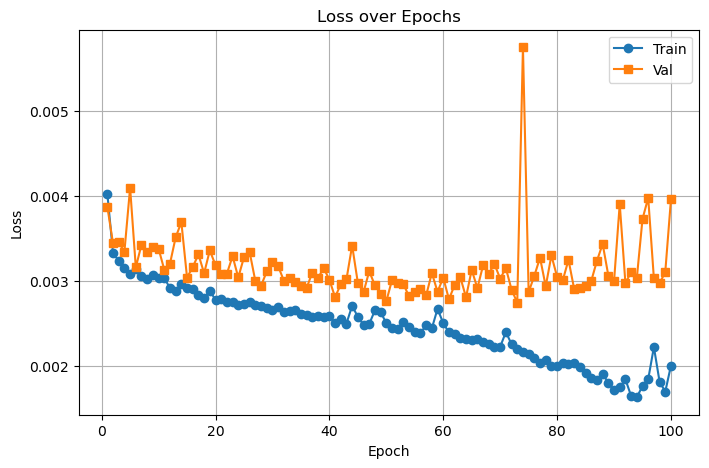

In [38]:
# Initialisieren des Trainingsprozess sowie aufrufen des Trainings und ausgabe der Durchgangsstatistik
trainer = Trainer(model = model, train_loader= train_loader, val_loader=val_loader, criterion=criterion, optimizer=optimizer, device=device, validate=True)
trainer.fit(num_epochs)

# 6. Lernkurve anzeigen
trainer.plot_history()

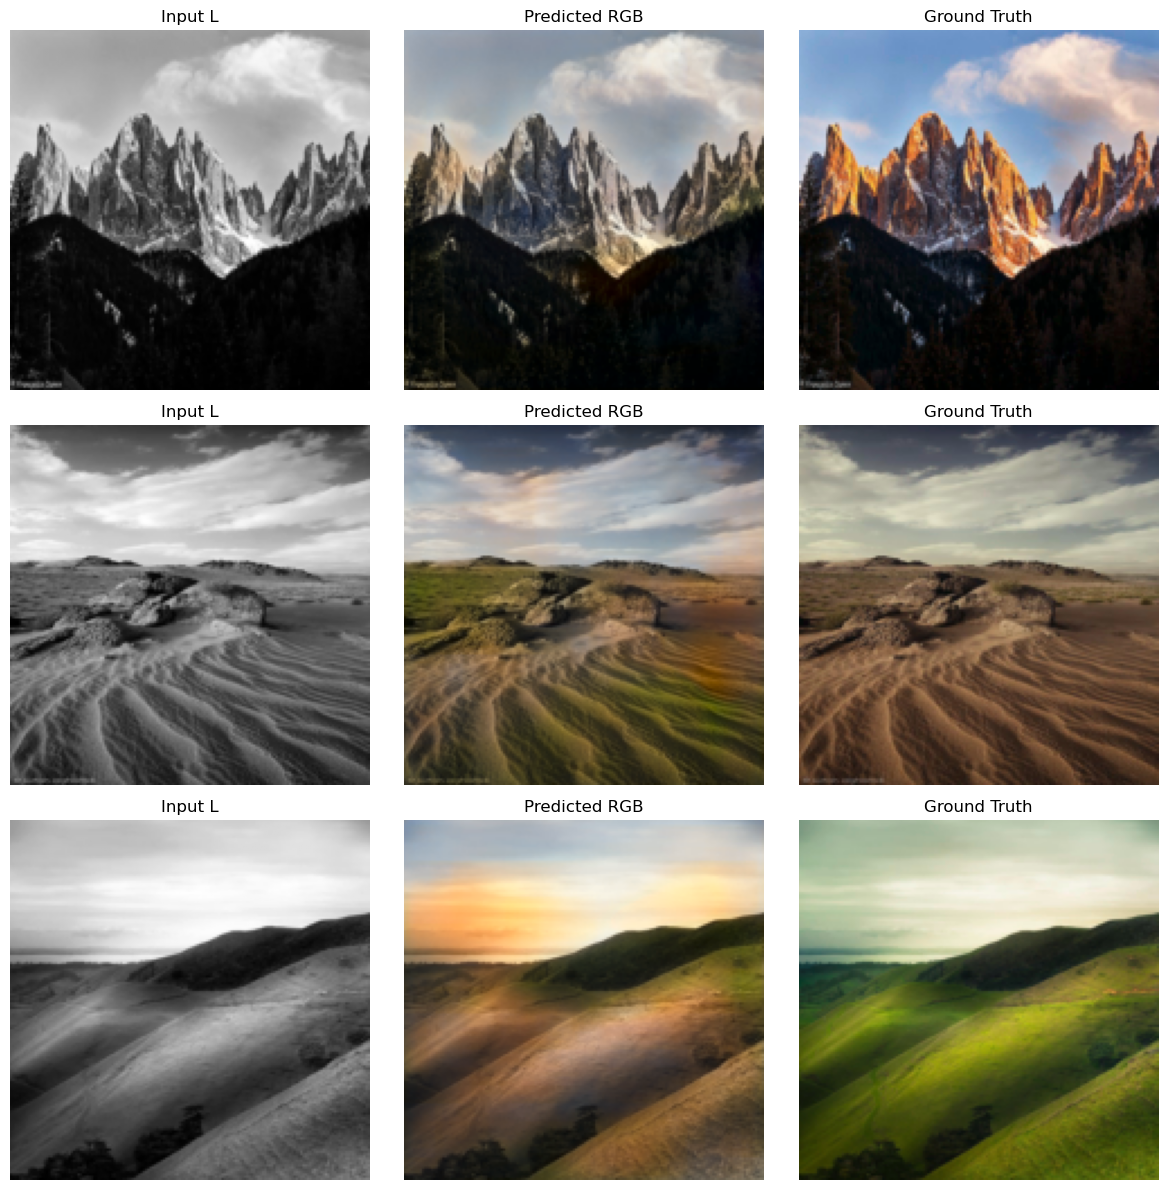

In [39]:
# Erste Visuelle Inspektion, hierfür wird der Testdatensatz verwendet
trainer.show_examples(test_loader)

In [40]:
# Bewertungskennzahlen zum evaluieren der Ergebnisse

psnr = evaluate_psnr(model, test_loader, device)
ssim = evaluate_ssim(model, test_loader, device)
ciede = evaluate_ciede2000(model, test_loader, device)
# PSNR > 40 dB: nahezu identisch // 30–40 dB: sehr gute Qualität // 20–30 dB: akzeptabel // < 20 dB: deutlich sichtbare Fehler
# ssim: 0 -> 1
# CIEDE2000: ΔE < 1 // 1,0 ≤ ΔE < 2,0 // 2,0 ≤ ΔE < 5,0 // ΔE ≥ 5,0
print(f"PSNR: {psnr:.2f} dB")
print(f"SSIM: {ssim:.4f}")
print(f"CIEDE2000: {ciede:.4f}")


PSNR: 22.53 dB
SSIM: 0.8788
CIEDE2000: 3.8582
